In [37]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Handling Networks

<img src="imgs/sheldon.gif">

### Let's continue our exploration of the show Big Bang Theory with a focus on it's graph structure!

First, load the data that we prepared for you the data in a nice format:

In [9]:
lines = pd.read_pickle("data/BBT_lines.pkl")
lines.head()

,Season,Episode,Scene,Character,Line
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.


And let's define the characters that we are interested to study:

In [6]:
recurrent_characters = ['Amy', 'Arthur', 'Bernadette', 'Bert', 'Beverley', 'Emily', 'Howard', 
                       'Leonard', 'Leslie', 'Penny', 'Priya', 'Raj', 'Sheldon', 'Stuart', 'Wil', 
                       'Zack', 'Lucy', 'Kripke', 'Isabella']

In [30]:
character_by_scene = lines.groupby('Scene').apply(lambda x: [c for c in set(x['Character']) if c in recurrent_characters])
character_by_scene.head()

Scene
(After a “previously on” sequence) A coffee shop                                          [Raj]
A Chinese restaurant.                                           [Howard, Sheldon, Raj, Leonard]
A Korean ballroom dancing club. Sheldon and Amy are dancing.                [Penny, Bernadette]
A Soyuz Spaceship capsule.                                                             [Howard]
A Swiss hotel room.                                                              [Leonard, Raj]
dtype: object

In [31]:
print(len(lines))
lines_ = lines[lines['Character'].isin(recurrent_characters)]
lines_ = lines_[lines['Line'].str.contains('|'.join(recurrent_characters))]
lines_['mentions'] = lines_.Line.apply(lambda x: [character for character in recurrent_characters if character in x])
print(len(lines_))
lines_.head()

51292
6940


,Season,Episode,Scene,Character,Line,mentions
13,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"Leonard, I don’t think I can do this.",[Leonard]
16,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Sheldon, this was your idea. A little extra mo...",[Sheldon]
52,1,Series 01 Episode 01 – Pilot Episode,The stairs of the apartment building.,Penny,"Oh, okay, well, guess I’m your new neighbour, ...",[Penny]
53,1,Series 01 Episode 01 – Pilot Episode,The stairs of the apartment building.,Leonard,"Leonard, Sheldon.","[Leonard, Sheldon]"
87,1,Series 01 Episode 01 – Pilot Episode,The stairs of the apartment building.,Sheldon,"Leonard, I’m not expert here but I believe in ...",[Leonard]


## The Gossip Graph

Let us define _gossip_ as follows: if a dialogue line of character A mentions B by name in a scene that does not involve character B, we say that “A gossips about B” in that line. Multiple mentions of the same person in a single line are counted once, but a character can gossip about several others in the same line. For the sake of simplicity, we only consider gossips where the name of the recurrent character is mentioned as it appears in our list of characters; for example, if someone says "Cooper" and they mean Sheldon, we discard that.

Create the two following graphs first:

1. Create the _familiarity graph_, an undirected weighted graph, in which there is a node for each recurrent character, and an edge between two characters if they appear together in at least one scene. The weight of the edge between them is the number of scenes they appear in together. If an edge exists between two people in the familiarity graph, we say that they "know each other".
2. Create the _gossip graph_, which is a directed weighted graph, in which there there is a node for each recurrent character, and a directed edge from the node for A to the node for B if A has gossiped about B at least once. The weight of the edge is the number of scenes in which A has gossiped about B.

Visualise both graphs.

In [33]:
familiarity_G = nx.Graph()
familiarity_G.add_nodes_from(recurrent_characters)

gossip_G = nx.DiGraph()
gossip_G.add_nodes_from(recurrent_characters)

for _, value in character_by_scene.iteritems():
    if len(value) > 1:
        for character in value[1:]:
            if familiarity_G.has_edge(value[0], character):
                familiarity_G[value[0]][character]['weight'] += 1
            else:
                familiarity_G.add_edge(value[0], character, weight=1)


for _, row in lines_.iterrows():
    for mention in row['mentions']:
        if mention not in character_by_scene[row['Scene']]:
            if gossip_G.has_edge(row['Character'], mention):
                gossip_G[row['Character']][mention]['weight'] += 1
            else:
                gossip_G.add_edge(row['Character'], mention, weight=1)

In [38]:
# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

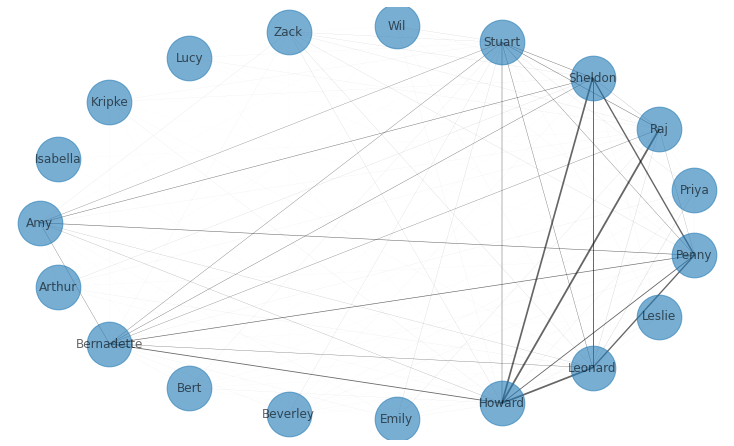

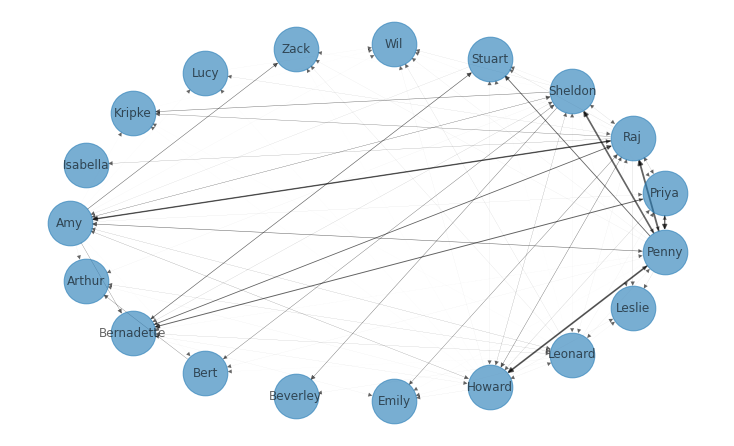

In [48]:
plt.figure(figsize=(10,6))
edges = familiarity_G.edges()
weights = [0.01*familiarity_G[u][v]['weight'] for u,v in edges]
nx.draw_shell(familiarity_G, with_labels=True, alpha = 0.6, node_size=2000, width=weights)
plt.figure(figsize=(10,6))
nx.draw_shell(gossip_G, with_labels=True, alpha = 0.6, node_size=2000, width=weights)


Now, answer the following questions:

**Q1: Who is the most mentioned person?**

In [49]:
import collections

weighted_degree = collections.Counter(dict(gossip_G.in_degree(weight='weight')))
weighted_degree.most_common()[0]

('Leonard', 127)

**Q2: Sheldon claims that every character in the show is familiar with everyone else through at most one intermediary. Based on the familiarity graph, is this true? If not, at most how many intermediaries are needed?**

In [52]:
nodes = list(familiarity_G.nodes)

one_intermediary = True
for source_idx in range(0, len(familiarity_G.nodes)):
    for destination_idx in range(source_idx+1, len(familiarity_G.nodes)):
        shortest_path = nx.shortest_path_length(familiarity_G, 
                                                source=nodes[source_idx], 
                                                target=nodes[destination_idx])
        if shortest_path>2:
            one_intermediary = False
            break

print("The claim of Sheldon is {}".format(one_intermediary))

The claim of Sheldon is True


**Q3. Who is the character through whom the largest number of these indirect familiarities happen? Calculate an appropriate centrality metric on the familiarity graph to answer this question.**

In [54]:
most_central_people = sorted(nx.betweenness_centrality(familiarity_G).items(), key=lambda r: -r[1])
most_central_people[:5]

[('Howard', 0.1111085174810665),
 ('Raj', 0.07734723519037244),
 ('Penny', 0.05228498806930179),
 ('Stuart', 0.05228498806930179),
 ('Leonard', 0.03322180724141509)]

**Q4. Another claim of Sheldon's is that every recurrent character in the show gossips about all the other recurrent characters. (A) Does the gossip graph possess that property?**

In [56]:
total_characters = len(recurrent_characters)
complete = True
for c in gossip_G.nodes:
    in_degree = gossip_G.in_degree(c, weight=None)
    if in_degree < total_characters-1:
        complete = False
        break
        
# Alternative: use out_degree

print("The claim of Sheldon that every recurrent character gossips about all the others is {}".format(complete))

The claim of Sheldon that every recurrent character gossips about all the others is False


**Q5. Use the gossip graph and the familiarity graph to figure out if for every pair of recurrent characters, one of them has gossiped about the other if and only if they know each other (shared a scene).**

In [58]:
# For every gossip edge, check if familiarity edge exists

for ge in gossip_G.edges:
    source = ge[0]
    destination = ge[1]
    if not familiarity_G.has_edge(source, destination):
        print("{} speaks about {} without sharing a scene".format(source, destination))

Amy speaks about Priya without sharing a scene
Amy speaks about Lucy without sharing a scene
Amy speaks about Kripke without sharing a scene
Bert speaks about Arthur without sharing a scene
Raj speaks about Leslie without sharing a scene
Raj speaks about Kripke without sharing a scene
Lucy speaks about Wil without sharing a scene
Kripke speaks about Wil without sharing a scene


## Quiz

**Quiz A: Given the following adjacency matrix of a graph:**

<img src="imgs/quizA.png">

1. A is a directed graph with average in-degree 4/3
2. A is an undirected graph with average degree 4/3
3. A is a directed graph with average in-degree 1
4. A is an undirected graph with average degree 1

In [17]:
1)

**Quiz B: In a horror scenario, your lost luggage is landing at an airport and being loaded to another random flight and transferred to another airport. This has been going on for months. Given a very large number of iterations, which of the following metrics gives you the probability that your luggage ends up in Geneva airport?**

1. Closeness centrality
2. Page rank
3. Betweenness centrality
4. Katz similarity

In [18]:
2)